# Geoelektrische Inversion

* Erstellung eines Modellierung- und Inversionsgitters
* Vorbereiten der Inversion
* Durchführen der Inversion
* Darstellung der Ergebnisse

In [19]:
import os
import crtomo
import reda

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import string
import copy

In [20]:
# create the modelling and inversion mesh
xz = np.zeros((48, 2))
xz[:, 0] = np.arange(0, 48*5, 5)
# xz[:, 1] = z

np.savetxt("electrodes.dat", xz, fmt="%.3f %.3f")

with open("boundaries.dat", "w") as fid:
    fid.write("-30 {:.3f} 12\n".format(xz[0, 1]))
    np.savetxt(
        fid,
        np.hstack((xz, np.ones(xz.shape[0])[:, np.newaxis] * 12)),
        fmt=["%.3f", "%.3f", "%i"],
    )
    xmax = xz[-1, 0] + 30
    zmin = xz[:, 1].min() - 80
    fid.write("{:.3f} {:.3f} 11\n".format(xmax, xz[-1, 1]))
    fid.write("{:.3f} {:.3f} 11\n".format(xmax, zmin))
    fid.write("-30 {:.3f} 11\n".format(zmin))
    
# create char_length.dat

with open('char_length.dat', 'w') as fid:
    fid.write('2.5\n')
    fid.write('10\n')
    fid.write('10\n')
    fid.write('10\n')

In [21]:
# run "cr_trig_create grid" from terminal
import subprocess
if os.path.isdir('grid'):
    print('Output directory "grid" already exists. Delete it manually and re-execute this cell to regenerate the mesh')
else:
    print('Generating mesh. Please wait until this command finished before proceeding')
    output = subprocess.check_output('cr_trig_create grid', shell=True)
    print('Done')

Output directory "grid" already exists. Delete it manually and re-execute this cell to regenerate the mesh


In [22]:
# load grid

grid = crtomo.crt_grid("grid/elem.dat", "grid/elec.dat")

electrode_positions = np.loadtxt("electrodes.dat")

This grid was sorted using CutMcK. The nodes were resorted!
Triangular grid found


In [23]:
grid.get_electrode_positions()

array([[  0.,   0.],
       [  5.,   0.],
       [ 10.,   0.],
       [ 15.,   0.],
       [ 20.,   0.],
       [ 25.,   0.],
       [ 30.,   0.],
       [ 35.,   0.],
       [ 40.,   0.],
       [ 45.,   0.],
       [ 50.,   0.],
       [ 55.,   0.],
       [ 60.,   0.],
       [ 65.,   0.],
       [ 70.,   0.],
       [ 75.,   0.],
       [ 80.,   0.],
       [ 85.,   0.],
       [ 90.,   0.],
       [ 95.,   0.],
       [100.,   0.],
       [105.,   0.],
       [110.,   0.],
       [115.,   0.],
       [120.,   0.],
       [125.,   0.],
       [130.,   0.],
       [135.,   0.],
       [140.,   0.],
       [145.,   0.],
       [150.,   0.],
       [155.,   0.],
       [160.,   0.],
       [165.,   0.],
       [170.,   0.],
       [175.,   0.],
       [180.,   0.],
       [185.,   0.],
       [190.,   0.],
       [195.,   0.],
       [200.,   0.],
       [205.,   0.],
       [210.,   0.],
       [215.,   0.],
       [220.,   0.],
       [225.,   0.],
       [230.,   0.],
       [235.,

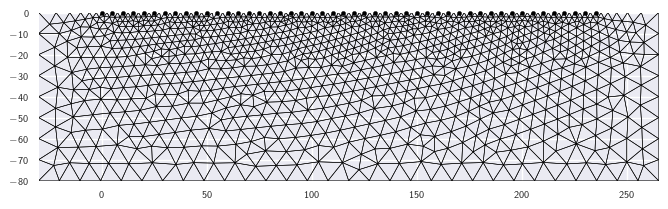

In [24]:
fig, ax = plt.subplots()
grid.plot_grid_to_ax(ax=ax)

## Vorbereiten der Inversion

In [25]:
path = "p2n.bin"

ERT = reda.ERT()
ERT.import_syscal_bin(path, spacing=5, check_meas_nums=False)

2023-12-13 10:31:47,996 - reda.containers.BaseContainer  - %INFO       - IRIS Syscal Pro bin import
2023-12-13 10:31:48,635 - reda.containers.BaseContainer  - %INFO       - Data sized changed from 0 to 1170


In [26]:
ERT.data

,a,b,m,n,r,Vmn,Iab,vab,mdelay,Tm,Mx,chargeability,q,id,norrec,rdiff
0,1,2,3,4,-0.361113,-295.741486,818.972900,272.421539,40.0,"[40.0, 80.0, 160.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[8.062434196472168, 4.241702556610107, 2.49223...",3.787824,0.070346,0,nor,NaN
1,1,2,4,5,-0.088333,-72.342644,818.972900,272.421539,40.0,"[40.0, 80.0, 160.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[11.57375717163086, 6.2800374031066895, 3.6966...",5.560038,0.178211,1,nor,NaN
2,1,2,5,6,-0.024835,-20.338915,818.972900,272.421539,40.0,"[40.0, 80.0, 160.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[12.065199851989746, 6.475801467895508, 4.1293...",5.933445,0.475597,2,nor,NaN
3,1,2,6,7,-0.010175,-8.333276,818.972900,272.421539,40.0,"[40.0, 80.0, 160.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[9.512491226196289, 5.911228179931641, 3.27109...",4.917046,1.058270,3,nor,NaN
4,1,2,7,8,-0.004769,-3.905498,818.972900,272.421539,40.0,"[40.0, 80.0, 160.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[10.882041931152344, 6.188399791717529, 3.5989...",5.379227,2.181146,4,nor,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,43,44,46,47,-0.032844,-25.753416,784.104980,258.844940,40.0,"[40.0, 80.0, 160.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[9.977911949157715, 5.490591049194336, 3.26226...",4.858307,0.275491,1165,nor,NaN
1166,43,44,47,48,-0.014845,-11.639729,784.104980,258.844940,40.0,"[40.0, 80.0, 160.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[14.841263771057129, 7.9800591468811035, 4.956...",7.232708,0.589601,1166,nor,NaN
1167,44,45,46,47,-0.134653,-115.504372,857.793152,238.503342,40.0,"[40.0, 80.0, 160.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[8.052447319030762, 4.407754421234131, 2.62471...",3.909544,0.226076,1167,nor,NaN
1168,44,45,47,48,-0.034317,-29.437243,857.793152,238.503342,40.0,"[40.0, 80.0, 160.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[9.079273223876953, 5.108961582183838, 3.24953...",4.613618,1.106579,1168,nor,NaN


In [27]:
K = reda.utils.geometric_factors.compute_K_numerical(
    ERT.data,
    {
        "rho": 100,
        "elem": "grid/elem.dat",
        "elec": "grid/elec.dat",
    }
)

_ = reda.utils.geometric_factors.apply_K(ERT.data, K)
_ = reda.utils.fix_sign_with_K.fix_sign_with_K(ERT.data)

SETTINGS
{'rho': 100, 'elem': 'grid/elem.dat', 'elec': 'grid/elec.dat'}
***FILES***
../grid/elem.dat
../grid/elec.dat
../rho/rho.dat
../config/config.dat
F
../mod/pot/pot.dat
T
../mod/volt.dat
F
../mod/sens/sens.dat
F
1
F
1660
F
boundary.dat


In [28]:
ERT.data["rhoa"] = ERT.data["r"] * ERT.data["k"]

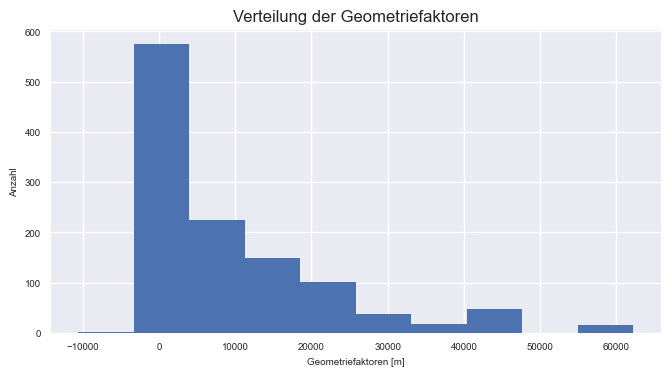

In [31]:
fig, ax = plt.subplots(figsize=(20 / 2.54, 10 / 2.54))
ERT.data["k"].hist(ax=ax)
ax.set_title('Verteilung der Geometriefaktoren')
ax.set_xlabel('Geometriefaktoren [m]')
_ = ax.set_ylabel('Anzahl')

In [32]:
ERT.filter("rhoa < 0")
ERT.filter("rhoa > 50")
ERT.filter("k > 50000")

# ERT.data

2023-12-13 10:32:40,149 - reda.containers.BaseContainer  - %INFO       - Data sized changed from 1170 to 1168
2023-12-13 10:32:40,154 - reda.containers.BaseContainer  - %INFO       - Data sized changed from 1168 to 1167
2023-12-13 10:32:40,159 - reda.containers.BaseContainer  - %INFO       - Data sized changed from 1167 to 1151


In [33]:
# create dirs for CRTomo
reda.exporters.crtomo.write_files_to_directory(ERT.data, ".")

In [34]:
# create CRTomo Manager, load data and set error parameters

tdm = crtomo.tdMan(elem_file="grid/elem.dat", elec_file="grid/elec.dat")

tdm.read_voltages("volt.dat")

tdm.crtomo_cfg["mag_rel"] = 1
tdm.crtomo_cfg["mag_abs"] = 1e-3

tdm.crtomo_cfg["dc_inv"] = "T"

tdm.crtomo_cfg["robust_inv"] = "F"
tdm.crtomo_cfg["diff_inv"] = "F"

This grid was sorted using CutMcK. The nodes were resorted!
Triangular grid found


In [35]:
!rm -r td

## Durchführen der Inversion

In [36]:
# das hier ist die eigentliche Inversion
# Dauert einige Minuten !
tdm.invert(cores=2, output_directory="td")

Attempting inversion in directory: td
Using binary: /usr/bin/CRTomo_dev
Calling CRTomo
Inversion finished
Attempting to import the results
is robust False
Info: res_m.diag not found: td/inv/res_m.diag
/home/mweigand/owncloud_sciebo/AngewandteGeophysikWS23-24/Notebooks/ERT
Info: ata.diag not found: td/inv/ata.diag
/home/mweigand/owncloud_sciebo/AngewandteGeophysikWS23-24/Notebooks/ERT
Statistics of last iteration:
iteration               3
main_iteration          3
it_type             DC/IP
type                 main
dataRMS            0.9951
magRMS             0.9951
phaRMS                0.0
lambda              12.88
roughness           31.98
cgsteps              66.0
nrdata             1151.0
steplength          0.001
stepsize          0.04816
l1ratio               NaN
Name: 34, dtype: object


0

In [37]:
# save the results into a pre-defined directory structure, called the "tomodir"
tdm.save_to_tomodir('td')

## Darstellung der Ergebnisse

In [72]:
# compute a plot mask based on the coverage (=cumulated sensitivity), which is a
# weak (!) indicator for data resolution
l1_coverage = 10 ** tdm.parman.parsets[
    tdm.a['inversion']['l1_dw_log10_norm']
] * 1

# show all cells with a coverage above the threshold in full (no alpha)
l1_coverage[l1_coverage > 8e-3] = 1

# add this mask to our inversion objectso we can refer to it later
cov_id = tdm.parman.add_data(l1_coverage)

0.0005863668855841165 1.0


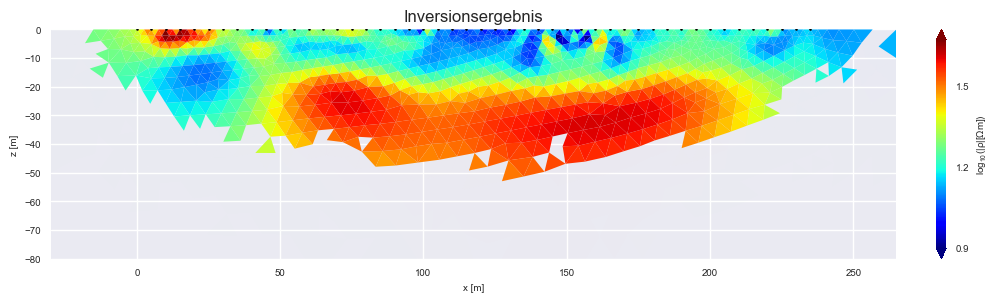

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))

pid_rmag = tdm.a["inversion"]["rmag"][-1]
rmag = tdm.parman.parsets[pid_rmag]

tdm.plot.plot_elements_to_ax(
    cid=pid_rmag,
    # comment out the next line to see the full inversion without an alpha mask
    cid_alpha=cov_id,
    ax=ax,
    plot_colorbar=True,
    cmap_name='jet',
    cblabel=r'$log_{10}(|\rho| [\Omega m])$',
    converter=np.log10,
    no_elecs=True
)
ax.scatter(
    electrode_positions[:, 0].flatten(),
    electrode_positions[:, 1].flatten(),
    marker=".",
    color="k"
)
ax.set_title("Inversionsergebnis")
# ax.set_title("mag rel: {}".format(mag_rel))
fig.tight_layout()

# fig.savefig("inversions_ergebnis.jpeg", bbox_inches="tight", dpi=300)